# Introduction

For this analysis, my research question would be what factors are associated with COVID-19 infection rates in the United States counties. I would be utilizing various datasets concerning county health information, county COVID-19 infection rates, county population densities, and state political affiliation. In turn, I would attempt to identify and evaluate risk factors connected to infection rates by doing multiple regression analysis. The resultant linear regression model would be used mainly for interpretation. The outcome of the study, if deemed to be insightful and significant, can be used to access a population's vulnerability to COVID-19 based on the community's characteristics from the reference point of the American counties.  

In [1]:
# Import necessary libraries 

import pandas as pd
import numpy as np 
import altair as alt
import statsmodels.formula.api as smf
import statsmodels.api as sm  
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy import stats
import itertools
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot as plt
from scipy.stats.mstats import zscore

alt.data_transformers.enable('json')

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


DataTransformerRegistry.enable('json')

# Data overview

Let's take a look at the datasets this analysis will be using. A few of them  are put together by crawling wiki pages. The rest are from what are provided officially.

In [2]:
# https://github.com/nytimes/covid-19-data
# Cumulative counts of coronavirus cases in the US at the county level
county_infection = pd.read_csv('relevant_data/us-counties.csv')

In [3]:
county_infection.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


In [4]:
county_infection.tail()

,date,county,state,fips,cases,deaths
141398,2020-05-13,Sublette,Wyoming,56035.0,3,0
141399,2020-05-13,Sweetwater,Wyoming,56037.0,20,0
141400,2020-05-13,Teton,Wyoming,56039.0,99,1
141401,2020-05-13,Uinta,Wyoming,56041.0,9,0
141402,2020-05-13,Washakie,Wyoming,56043.0,7,0


> The latest date of the data is May 13th, 2020.

In [5]:
county_infection[(county_infection['state'] == 'Illinois') & (county_infection['county'] == 'Cook')]

,date,county,state,fips,cases,deaths
3,2020-01-24,Cook,Illinois,17031.0,1,0
6,2020-01-25,Cook,Illinois,17031.0,1,0
11,2020-01-26,Cook,Illinois,17031.0,1,0
16,2020-01-27,Cook,Illinois,17031.0,1,0
21,2020-01-28,Cook,Illinois,17031.0,1,0
...,...,...,...,...,...,...
127415,2020-05-09,Cook,Illinois,17031.0,51674,2264
130328,2020-05-10,Cook,Illinois,17031.0,52655,2317
133240,2020-05-11,Cook,Illinois,17031.0,53381,2361
136151,2020-05-12,Cook,Illinois,17031.0,55470,2449


In [6]:
county_infection[(county_infection['state'] == 'California') & (county_infection['county'] == 'Santa Clara')]

,date,county,state,fips,cases,deaths
36,2020-01-31,Santa Clara,California,6085.0,1,0
42,2020-02-01,Santa Clara,California,6085.0,1,0
50,2020-02-02,Santa Clara,California,6085.0,2,0
58,2020-02-03,Santa Clara,California,6085.0,2,0
66,2020-02-04,Santa Clara,California,6085.0,2,0
...,...,...,...,...,...,...
127045,2020-05-09,Santa Clara,California,6085.0,2307,131
129957,2020-05-10,Santa Clara,California,6085.0,2339,131
132869,2020-05-11,Santa Clara,California,6085.0,2341,131
135780,2020-05-12,Santa Clara,California,6085.0,2364,134


> It seems like each county's data starts with the first case of infection and then contains each subsequent day's cumulative count.

In [7]:
# https://en.wikipedia.org/wiki/County_(United_States)
# County population and density
county_population = pd.read_csv('relevant_data/county-population.csv')

In [8]:
county_population.head()

,state,county,population,land_area_km,density_km
0,Alabama,Autauga,54571,1540,35.436
1,Alabama,Baldwin,182265,4118,44.261
2,Alabama,Barbour,27457,2292,11.979
3,Alabama,Bibb,22915,1612,14.215
4,Alabama,Blount,57322,1670,34.325


In [9]:
# https://en.wikipedia.org/wiki/Political_party_strength_in_U.S._states
# https://en.wikipedia.org/wiki/List_of_United_States_governors
# State party affiliation based on house representation
state_party_line = pd.read_csv('relevant_data/state_party_line.csv')

In [10]:
state_party_line.head()

,state,state_house_blue_perc,state_governor_party
0,Alabama,22.86,red
1,Alaska,35.00,red
2,Arizona,43.33,red
3,Arkansas,25.71,red
4,California,72.50,blue


In [11]:
# Source: https://www.countyhealthrankings.org/
# Access: https://app.namara.io/#/data_sets/579ee1c6-8f66-418c-9df9-d7b5b618c774?organizationId=5ea77ea08fb3bf000c9879a1
# County health information
county_health = pd.read_csv('relevant_data/us-county-health-rankings-2020.csv')

In [12]:
county_health.head()

,fips,state,county,num_deaths,years_of_potential_life_lost_rate,95percent_ci_low,95percent_ci_high,quartile,ypll_rate_aian,ypll_rate_aian_95percent_ci_low,...,percent_hispanic,num_non_hispanic_white,percent_non_hispanic_white,num_not_proficient_in_english,percent_not_proficient_in_english,95percent_ci_low_39,95percent_ci_high_39,percent_female,num_rural,percent_rural
0,1000,Alabama,NaN,81791.0,9942.794666,9840.535949,10045.053384,NaN,NaN,NaN,...,4.443264,3197324,65.413428,48517,1.061048,1.006759,1.115337,51.633032,1957932.0,40.963183
1,1001,Alabama,Autauga,791.0,8128.591190,7283.340731,8973.841649,1.0,NaN,NaN,...,2.965774,41316,74.308016,426,0.820225,0.347891,1.292558,51.448715,22921.0,42.002162
2,1003,Alabama,Baldwin,2967.0,7354.122530,6918.554269,7789.690790,1.0,NaN,NaN,...,4.646779,181201,83.111337,1068,0.543517,0.347271,0.739763,51.538377,77060.0,42.279099
3,1005,Alabama,Barbour,472.0,10253.573403,8782.217281,11724.929524,2.0,NaN,NaN,...,4.276355,11356,45.641252,398,1.631683,0.824903,2.438462,47.216752,18613.0,67.789635
4,1007,Alabama,Bibb,471.0,11977.539484,10344.064842,13611.014126,3.0,NaN,NaN,...,2.625000,16708,74.589286,57,0.268210,0.000000,0.807504,46.781250,15663.0,68.352607


In [13]:
county_health.columns[:75]

Index(['fips', 'state', 'county', 'num_deaths',
       'years_of_potential_life_lost_rate', '95percent_ci_low',
       '95percent_ci_high', 'quartile', 'ypll_rate_aian',
       'ypll_rate_aian_95percent_ci_low', 'ypll_rate_aian_95percent_ci_high',
       'ypll_rate_asian', 'ypll_rate_asian_95percent_ci_low',
       'ypll_rate_asian_95percent_ci_high', 'ypll_rate_black',
       'ypll_rate_black_95percent_ci_low', 'ypll_rate_black_95percent_ci_high',
       'ypll_rate_hispanic', 'ypll_rate_hispanic_95percent_ci_low',
       'ypll_rate_hispanic_95percent_ci_high', 'ypll_rate_white',
       'ypll_rate_white_95percent_ci_low', 'ypll_rate_white_95percent_ci_high',
       'percent_fair_or_poor_health', '95percent_ci_low_2',
       '95percent_ci_high_2', 'quartile_2',
       'average_number_of_physically_unhealthy_days', '95percent_ci_low_3',
       '95percent_ci_high_3', 'quartile_3',
       'average_number_of_mentally_unhealthy_days', '95percent_ci_low_4',
       '95percent_ci_high_4', 'quar

> This dataset contains extensive information about a county's attributes, including the rankings, quantiles, rates, and percentages of numerous demographic as well as health qualities. Of the many measurements of each quality, we probably only need one or two to avoid duplication. In addition, I will do a **factor analysis** on the columns to see if it makes sense.

For more information about these columns, please visit this [info](https://app.namara.io/#/data_sets/579ee1c6-8f66-418c-9df9-d7b5b618c774/info?organizationId=5ea77ea08fb3bf000c9879a1) page

# Data wrangling

In this section, we want to prepare our data for further exploration and analysis. 

In [14]:
# Aggregate data related to county infection and basic characteristics
county = county_infection.merge(
    county_population, left_on=['county', 'state'], right_on=['county', 'state']
).merge(
    state_party_line, left_on=['state'], right_on=['state']
)

In [15]:
county.sample(5)

,date,county,state,fips,cases,deaths,population,land_area_km,density_km,state_house_blue_perc,state_governor_party
122337,2020-03-26,Moniteau,Missouri,29135.0,2,0,15607,1080,14.451,29.41,red
53398,2020-05-02,Queen Anne's,Maryland,24035.0,57,8,48595,1321,36.787,68.09,red
120647,2020-05-12,Lincoln,Maine,23015.0,15,0,33969,1813,18.736,60.00,blue
2558,2020-03-26,Lake,Illinois,17097.0,185,0,703462,1160,606.433,67.80,blue
110511,2020-04-13,Drew,Arkansas,5043.0,6,1,18509,2164,8.553,25.71,red


Let's look at the statistics of the counted days for the counties

In [16]:
# Count the number of days each county data has
def count_days(series):
    time_series = pd.to_datetime(series)
    first_date = time_series.iloc[0]
    last_date = time_series.iloc[-1]
    
    return (last_date - first_date).days + 1

In [17]:
grouped_county = county.groupby(['state', 'county']).agg(days_counted=('date', count_days))

In [18]:
grouped_county.describe()

,days_counted
count,2758.000000
mean,48.719362
std,12.420495
min,1.000000
25%,43.000000
50%,50.000000
75%,56.000000
max,114.000000


In [19]:
grouped_county.shape

(2758, 1)

> We have 2758 counties in the data. The minimum amount of days counted for a county is only one, while the maximum is about almost four months. I am happy that the median is 50 days. Ideally, I want all counties in the analysis to have at least two months worth of data so that any of its heath characteristics can have a decent chance of exerting its influence if there could be any at all. With the current data and analysis, I will only include counties with 50 day worth of data to maximize the representativeness of the eventual infection picture and not exclude too much data. Please understand that I'm not a domain expert. I apologize that this cutoff point seems rather arbitrary, but I hope the rationale makes sense domain-wise.

With that said, for the next step, we want to group the infection data by counties and create a bunch of aggregated columns including counted days, confirmed infection in the percentage of county population, death rate, and raw infection counts. We will also calculate those columns for the cutoff point of 50 days so that we can do the analysis without accounting for the number of days for model simplicity. This is also where we will exclude counties that have less than 50 days of data.

In [20]:
# Find the value at the 50 day mark
def county_cumulative_days(series, days = 50):
    # This may not be 100% accurate because perhaps some days are missing, 
    # but that seems to happen rarely. So this should be accurate enough.
    if len(series) < days:
        return series.iloc[-1]
    else:
        return series.iloc[days - 1]

In [21]:
# Group our data in terms of county and aggregate some columns to show overall infection rate 
# and death rate as well as at the 50 day mark
def group_county_data(data):
    grouped_data = data.groupby(['state', 'county']).agg(
        population=('population', lambda x: x.iloc[-1]),
        density_km=('density_km', lambda x: x.iloc[-1]),
        state_house_blue_perc=('state_house_blue_perc', lambda x: x.iloc[-1]),
        state_governor_party=('state_governor_party', lambda x: x.iloc[-1]),
        days_counted=('date', count_days),
        case_sum=('cases', lambda x: x.iloc[-1]),
        death_sum=('deaths', lambda x: x.iloc[-1]),
        case_count_50_days=('cases', county_cumulative_days),
        death_count_50_days=('deaths', county_cumulative_days)
    )
    
    grouped_data = grouped_data[grouped_data['days_counted'] >= 50]
    grouped_data['infection_rate'] = grouped_data['case_sum']/grouped_data['population']*100
    grouped_data['death_rate'] = grouped_data['death_sum']/grouped_data['case_sum']*100
    grouped_data = grouped_data[grouped_data['infection_rate'] != float("inf")]
    grouped_data['infection_rate_50_days'] = grouped_data['case_count_50_days']/grouped_data['population']*100
    grouped_data['death_rate_50_days'] = grouped_data['death_count_50_days']/grouped_data['case_count_50_days']*100
    
    return grouped_data.reset_index()

In [22]:
grouped_county = group_county_data(county)

In [23]:
grouped_county

,state,county,population,density_km,state_house_blue_perc,state_governor_party,days_counted,case_sum,death_sum,case_count_50_days,death_count_50_days,infection_rate,death_rate,infection_rate_50_days,death_rate_50_days
0,Alabama,Autauga,54571,35.436,22.86,red,51,93,4,91,4,0.170420,4.301075,0.166755,4.395604
1,Alabama,Baldwin,182265,44.261,22.86,red,61,231,7,181,4,0.126739,3.030303,0.099306,2.209945
2,Alabama,Blount,57322,34.325,22.86,red,50,45,0,45,0,0.078504,0.000000,0.078504,0.000000
3,Alabama,Butler,20947,10.411,22.86,red,50,230,6,230,6,1.098009,2.608696,1.098009,2.608696
4,Alabama,Calhoun,118572,75.572,22.86,red,57,127,3,114,3,0.107108,2.362205,0.096144,2.631579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,Wyoming,Natrona,78621,5.684,10.00,red,55,48,0,48,0,0.061052,0.000000,0.061052,0.000000
1459,Wyoming,Park,28702,1.596,10.00,red,58,1,0,1,0,0.003484,0.000000,0.003484,0.000000
1460,Wyoming,Sheridan,29596,4.529,10.00,red,64,16,0,16,0,0.054061,0.000000,0.054061,0.000000
1461,Wyoming,Sweetwater,45267,1.676,10.00,red,51,20,0,20,0,0.044182,0.000000,0.044182,0.000000


> We end up with 1463 counties, which is decent.

In [24]:
grouped_county.sample(5)

,state,county,population,density_km,state_house_blue_perc,state_governor_party,days_counted,case_sum,death_sum,case_count_50_days,death_count_50_days,infection_rate,death_rate,infection_rate_50_days,death_rate_50_days
175,Connecticut,Tolland,152691,143.777,61.11,blue,56,560,49,522,46,0.366754,8.750000,0.341867,8.812261
694,Mississippi,Calhoun,14962,9.843,30.77,red,50,58,4,58,4,0.387649,6.896552,0.387649,6.896552
297,Georgia,Pickens,29268,48.699,37.50,red,55,36,3,32,2,0.123001,8.333333,0.109334,6.250000
894,New York,Tioga,51125,37.731,63.49,blue,61,108,16,90,6,0.211247,14.814815,0.176039,6.666667
239,Georgia,Chatham,276434,242.486,37.50,red,55,337,14,291,12,0.121910,4.154303,0.105269,4.123711


Next, let's tackle county health data.

In [25]:
# Remove state total rows first
county_health = county_health.dropna(subset=['county'])

Take a quick look over the data again.

In [26]:
county_health.sample(5)

,fips,state,county,num_deaths,years_of_potential_life_lost_rate,95percent_ci_low,95percent_ci_high,quartile,ypll_rate_aian,ypll_rate_aian_95percent_ci_low,...,percent_hispanic,num_non_hispanic_white,percent_non_hispanic_white,num_not_proficient_in_english,percent_not_proficient_in_english,95percent_ci_low_39,95percent_ci_high_39,percent_female,num_rural,percent_rural
2882,51031,Virginia,Campbell,790.0,7451.466365,6593.748490,8309.184240,2.0,NaN,NaN,...,2.759536,43723,79.535408,336,0.640940,0.272054,1.009826,51.388864,33516.0,61.113745
2400,45087,South Carolina,Union,616.0,11139.804410,9732.917211,12546.691609,3.0,NaN,NaN,...,1.685516,17601,64.213791,44,0.168589,0.000000,0.595850,52.619482,18928.0,65.356859
1709,31055,Nebraska,Douglas,5723.0,6440.111363,6208.198013,6672.024713,2.0,15883.249855,11494.786676,...,12.828288,391835,69.121331,19690,3.839584,3.578455,4.100712,50.628352,11224.0,2.170525
224,6067,California,Sacramento,16234.0,6339.749651,6200.661158,6478.838144,2.0,9711.096642,7553.048409,...,23.447363,681438,44.221224,92841,6.581355,NaN,NaN,51.136650,29257.0,2.062112
3118,55043,Wisconsin,Grant,476.0,5212.192289,4457.453245,5966.931333,1.0,NaN,NaN,...,1.829150,48909,94.869457,166,0.338596,0.168284,0.508908,48.137875,33023.0,64.487971


In [27]:
county_health.columns

Index(['fips', 'state', 'county', 'num_deaths',
       'years_of_potential_life_lost_rate', '95percent_ci_low',
       '95percent_ci_high', 'quartile', 'ypll_rate_aian',
       'ypll_rate_aian_95percent_ci_low',
       ...
       'percent_hispanic', 'num_non_hispanic_white',
       'percent_non_hispanic_white', 'num_not_proficient_in_english',
       'percent_not_proficient_in_english', '95percent_ci_low_39',
       '95percent_ci_high_39', 'percent_female', 'num_rural', 'percent_rural'],
      dtype='object', length=507)

In [28]:
county_health.columns[:100]

Index(['fips', 'state', 'county', 'num_deaths',
       'years_of_potential_life_lost_rate', '95percent_ci_low',
       '95percent_ci_high', 'quartile', 'ypll_rate_aian',
       'ypll_rate_aian_95percent_ci_low', 'ypll_rate_aian_95percent_ci_high',
       'ypll_rate_asian', 'ypll_rate_asian_95percent_ci_low',
       'ypll_rate_asian_95percent_ci_high', 'ypll_rate_black',
       'ypll_rate_black_95percent_ci_low', 'ypll_rate_black_95percent_ci_high',
       'ypll_rate_hispanic', 'ypll_rate_hispanic_95percent_ci_low',
       'ypll_rate_hispanic_95percent_ci_high', 'ypll_rate_white',
       'ypll_rate_white_95percent_ci_low', 'ypll_rate_white_95percent_ci_high',
       'percent_fair_or_poor_health', '95percent_ci_low_2',
       '95percent_ci_high_2', 'quartile_2',
       'average_number_of_physically_unhealthy_days', '95percent_ci_low_3',
       '95percent_ci_high_3', 'quartile_3',
       'average_number_of_mentally_unhealthy_days', '95percent_ci_low_4',
       '95percent_ci_high_4', 'quar

> There are 507 columns. To reiterate my proposed course of action, we want to first get rid of many different measurements of the same quality and only keep the rates. We also want to remove some redundant columns such as population. The purpose is to hopefully keep the complexity under a managable level, while maintaining the values of the information.

In [29]:
excluded_column_words = [
    'quartile',
    'ci_high',
    'ci_low',
    'fips',
    'num',
    'denominator',
    'ratio',
    'population',
]

In [30]:
filtered_columns = county_health.columns[~county_health.columns.str.contains('|'.join(excluded_column_words))]

In [31]:
print(str(len(filtered_columns)) + ' columns remain!')

190 columns remain!


In [32]:
filtered_county_health = county_health[filtered_columns]

Next, let's merge the health data into the infection data, and check out the merged data.

In [33]:
county = grouped_county.merge(
    filtered_county_health, left_on=['county', 'state'], right_on=['county', 'state']
)

In [34]:
county

,state,county,population,density_km,state_house_blue_perc,state_governor_party,days_counted,case_sum,death_sum,case_count_50_days,...,percent_65_and_over,percent_black,percent_american_indian_alaska_native,percent_asian,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural
0,Alabama,Autauga,54571,35.436,22.86,red,51,93,4,91,...,15.562670,19.343177,0.480207,1.224798,0.111509,2.965774,74.308016,0.820225,51.448715,42.002162
1,Alabama,Baldwin,182265,44.261,22.86,red,61,231,7,181,...,20.443350,8.783976,0.772399,1.150343,0.066966,4.646779,83.111337,0.543517,51.538377,42.279099
2,Alabama,Blount,57322,34.325,22.86,red,50,45,0,45,...,18.236515,1.462656,0.653527,0.319848,0.121024,9.571231,86.886238,1.724520,50.726141,89.951502
3,Alabama,Butler,20947,10.411,22.86,red,50,230,6,230,...,20.299797,44.557927,0.376016,1.316057,0.050813,1.509146,51.255081,0.494155,53.429878,71.232157
4,Alabama,Calhoun,118572,75.572,22.86,red,57,127,3,114,...,17.717476,20.850215,0.539916,0.964324,0.110258,3.910673,72.024992,0.991376,51.946586,33.696826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,Wyoming,Natrona,78621,5.684,10.00,red,55,48,0,48,...,15.395311,1.161600,1.466220,0.827909,0.098591,8.581179,86.599254,0.731123,49.617645,14.449304
1458,Wyoming,Park,28702,1.596,10.00,red,58,1,0,1,...,23.206247,0.682035,0.944619,0.821852,0.057973,5.623380,90.915291,0.627835,50.194380,44.240383
1459,Wyoming,Sheridan,29596,4.529,10.00,red,64,16,0,16,...,20.993616,0.797142,1.366057,0.823603,0.112460,4.342937,91.482817,0.348727,49.793272,35.478775
1460,Wyoming,Sweetwater,45267,1.676,10.00,red,51,20,0,20,...,12.111217,1.145153,1.544680,1.010429,0.157952,16.083250,79.312908,1.633221,48.544749,10.916313


> We still have a lot of columns. Perhaps a lot of them have missing data for more than half of the data. We have no reasonable and accessible way of dealing with missing data here. We could fill in missing values from nearby counties, but that could be both erroneous and difficult. As a result, we will simply get rid of missing data in terms of columns and rows. Let's deal with columns first because we want to keep as many as rows as possible.

In [35]:
# Let's see the columns at near 90% cutoff points
county.dropna(thresh=1300, axis=1).info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1461
Data columns (total 91 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   state                                               1462 non-null   object 
 1   county                                              1462 non-null   object 
 2   population                                          1462 non-null   int64  
 3   density_km                                          1462 non-null   float64
 4   state_house_blue_perc                               1462 non-null   float64
 5   state_governor_party                                1462 non-null   object 
 6   days_counted                                        1462 non-null   int64  
 7   case_sum                                            1462 non-null   int64  
 8   death_sum                                           1462 non-null   int64  
 9

> At the 90% row number cutoff point, we have a decent amount of columns. Most of the columns seem important, so we will try to keep most of them by setting the cutoff point at 1370 rows to keep the indexes related to suicide.

In [36]:
county.dropna(thresh=1370, axis=1).dropna()

,state,county,population,density_km,state_house_blue_perc,state_governor_party,days_counted,case_sum,death_sum,case_count_50_days,...,percent_65_and_over,percent_black,percent_american_indian_alaska_native,percent_asian,percent_native_hawaiian_other_pacific_islander,percent_hispanic,percent_non_hispanic_white,percent_not_proficient_in_english,percent_female,percent_rural
0,Alabama,Autauga,54571,35.436,22.86,red,51,93,4,91,...,15.562670,19.343177,0.480207,1.224798,0.111509,2.965774,74.308016,0.820225,51.448715,42.002162
1,Alabama,Baldwin,182265,44.261,22.86,red,61,231,7,181,...,20.443350,8.783976,0.772399,1.150343,0.066966,4.646779,83.111337,0.543517,51.538377,42.279099
2,Alabama,Blount,57322,34.325,22.86,red,50,45,0,45,...,18.236515,1.462656,0.653527,0.319848,0.121024,9.571231,86.886238,1.724520,50.726141,89.951502
3,Alabama,Butler,20947,10.411,22.86,red,50,230,6,230,...,20.299797,44.557927,0.376016,1.316057,0.050813,1.509146,51.255081,0.494155,53.429878,71.232157
4,Alabama,Calhoun,118572,75.572,22.86,red,57,127,3,114,...,17.717476,20.850215,0.539916,0.964324,0.110258,3.910673,72.024992,0.991376,51.946586,33.696826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,Wyoming,Laramie,94483,13.581,10.00,red,58,173,1,162,...,16.028128,2.417758,1.169981,1.365988,0.134376,14.795506,78.501859,0.823311,49.310944,19.784604
1457,Wyoming,Natrona,78621,5.684,10.00,red,55,48,0,48,...,15.395311,1.161600,1.466220,0.827909,0.098591,8.581179,86.599254,0.731123,49.617645,14.449304
1458,Wyoming,Park,28702,1.596,10.00,red,58,1,0,1,...,23.206247,0.682035,0.944619,0.821852,0.057973,5.623380,90.915291,0.627835,50.194380,44.240383
1459,Wyoming,Sheridan,29596,4.529,10.00,red,64,16,0,16,...,20.993616,0.797142,1.366057,0.823603,0.112460,4.342937,91.482817,0.348727,49.793272,35.478775


We are keeping a good amount of data. Let's go ahead with that decision.

In [37]:
county = county.dropna(thresh=1370, axis=1).dropna()

# Factor analysis

After data wrangling, we are still dealing with a large number of columns. If we continue with our anaylsis as is, it might suffer from the curse of dimensionality. Also, if we are to include interaction terms, the number of parameters could get close to the number of rows. Furthermore, there is a high chance that we will run into multicollinearity. For all these reaons, I have decided to run factor anaylsis as the next step to reduce dimensionality and find independant latent variables. Please refer to its [wiki](https://en.wikipedia.org/wiki/Factor_analysis) for more information on the technique itself.

In [38]:
# Exclude columns that won't be used as explanatory variables and can't used in factor analysis
excluded_columns = [
    'state',
    'county', 
    'population',
    'state_house_blue_perc',
    'state_governor_party',
    'days_counted', 
    'case_sum', 
    'death_sum', 
    'case_count_50_days',
    'death_count_50_days', 
    'infection_rate', 
    'death_rate',
    'infection_rate_50_days', 
    'death_rate_50_days'
]

In [39]:
county_non_factor = county[excluded_columns]

In [40]:
county_factor = county.drop(excluded_columns, axis=1)

In [41]:
county_factor['presence_of_water_violation'] = county_factor['presence_of_water_violation'].apply(lambda x: 0 if x == 'f' else 1)

In [42]:
len(county_factor.columns)

73

In [43]:
county_factor.columns

Index(['density_km', 'years_of_potential_life_lost_rate',
       'percent_fair_or_poor_health', 'percent_low_birthweight',
       'percent_smokers', 'percent_adults_with_obesity',
       'food_environment_index', 'percent_physically_inactive',
       'percent_with_access_to_exercise_opportunities',
       'percent_excessive_drinking',
       'percent_driving_deaths_with_alcohol_involvement', 'chlamydia_rate',
       'teen_birth_rate', 'percent_uninsured', 'primary_care_physicians_rate',
       'dentist_rate', 'mental_health_provider_rate',
       'preventable_hospitalization_rate', 'percent_with_annual_mammogram',
       'percent_vaccinated', 'high_school_graduation_rate',
       'percent_some_college', 'labor_force', 'percent_unemployed',
       'percent_children_in_poverty', 'percent_children_in_poverty_white',
       '80th_percentile_income', '20th_percentile_income',
       'percent_single_parent_households', 'social_association_rate',
       'annual_average_violent_crimes', 'viole

Let's check whether factor anaylsis is appropriate first. We will be using [Bartlett’s Test](https://en.wikipedia.org/wiki/Bartlett's_test) and [Kaiser-Meyer-Olkin Test](https://www.statisticshowto.com/kaiser-meyer-olkin/). The former is used to access whether or not the variables intercorrelate. The latter measures the suitability of data for factor analysis.

In [44]:
chi_square_value, p_value = calculate_bartlett_sphericity(county_factor)

In [45]:
chi_square_value, p_value

(133128.6782521973, 0.0)

> The test was staistically significant, indicating that there is no homoscedasticity among the variables. 

In [46]:
kmo_all, kmo_model = calculate_kmo(county_factor)

In [47]:
kmo_model

0.8819556506099021

> This score indicates that the data is excellent for factor analysis.

Let's check out all the original eigenvalues first.

In [48]:
fa = FactorAnalyzer()

# Using the varimax rotation because it makes it easier to identify each variable with a single factor and
# it is commonly used for research purposes.
fa.set_params(rotation='varimax')
fa.fit(county_factor)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=3, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [49]:
ev, v = fa.get_eigenvalues()
ev[:30]

array([21.10420245,  9.75205054,  5.31700225,  4.89272699,  2.63759762,
        2.23636022,  2.11322333,  1.83241289,  1.52581256,  1.40173386,
        1.36418337,  1.21798421,  1.04606268,  0.99900303,  0.89745976,
        0.87265508,  0.83575177,  0.76188301,  0.68177795,  0.65631518,
        0.61357276,  0.58683493,  0.54375382,  0.52749695,  0.47823895,
        0.46437104,  0.4429748 ,  0.42959079,  0.41286415,  0.38816064])

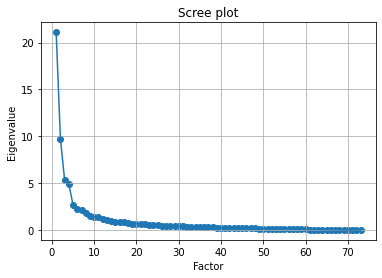

In [50]:
plt.scatter(range(1, len(ev)+1), ev)
plt.plot(range(1, len(ev)+1), ev)
plt.title('Scree plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

> It seems like we have 14 factors that are significant (bigger than or equal to one eigenvalue).

In [51]:
fa = FactorAnalyzer()
fa.set_params(n_factors=14, rotation='varimax')
fa.fit(county_factor)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=14, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [52]:
factor_loading = pd.DataFrame(fa.loadings_)

In [53]:
factor_loading.index = county_factor.columns

In [54]:
factor_loading.shape

(73, 14)

In [55]:
factor_loading

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
density_km,-0.121633,0.190903,0.047885,0.151452,-0.007275,0.063261,0.039574,0.258152,0.106125,0.659800,0.012003,-0.047507,0.148716,0.055539
years_of_potential_life_lost_rate,0.904692,-0.064771,-0.127782,-0.211906,0.062767,-0.012102,0.005048,-0.021228,0.155395,-0.033469,0.121411,0.087103,0.046574,0.036673
percent_fair_or_poor_health,0.866515,0.095270,0.268050,0.092894,0.195840,-0.042891,0.105292,-0.040598,0.019478,-0.028724,0.037751,-0.071608,0.013784,-0.102490
percent_low_birthweight,0.684445,0.109153,-0.119572,0.132819,0.152534,0.049138,0.054121,0.021557,0.244714,0.061772,-0.164195,0.283911,0.069785,-0.161012
percent_smokers,0.809222,-0.086118,-0.249687,-0.056897,-0.072469,-0.049220,0.101442,-0.069378,-0.100713,-0.051706,0.074872,-0.097321,0.118757,-0.027535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
percent_hispanic,-0.087359,0.140271,0.852495,0.061380,0.287112,-0.034441,0.077964,0.080489,-0.060265,0.013370,-0.014540,0.026099,0.090088,0.030808
percent_non_hispanic_white,-0.285367,-0.287643,-0.523167,-0.298240,-0.307008,-0.028853,-0.227799,-0.129927,-0.248308,-0.175134,-0.064753,-0.370864,-0.048669,0.155608
percent_not_proficient_in_english,-0.090683,0.205590,0.807595,0.232836,0.225034,0.002486,0.060863,0.146274,-0.037392,0.177529,0.023720,-0.035468,0.073040,0.121942
percent_female,0.145680,0.140029,-0.139769,0.183589,0.058448,0.266066,-0.034291,0.104924,0.359413,-0.095036,-0.026369,0.053149,0.153598,0.119879


## Factor interpretation

Now that we have collected all the significant factors, let's interpret them one by one. We will look at columns that have decent loadings(>|0.3|) for easier interpretations.

In [56]:
def filter_decent_loadings(factor):
    return factor[(factor > 0.3) | (factor < -0.3)]

In [57]:
for factor in factor_loading.columns:
    print('Factor ' + str(factor + 1) + ' loadings: ')
    print()
    print(filter_decent_loadings(factor_loading[factor]))
    print()
    print()

Factor 1 loadings: 

years_of_potential_life_lost_rate                0.904692
percent_fair_or_poor_health                      0.866515
percent_low_birthweight                          0.684445
percent_smokers                                  0.809222
percent_adults_with_obesity                      0.667487
food_environment_index                          -0.694481
percent_physically_inactive                      0.767988
percent_with_access_to_exercise_opportunities   -0.532579
percent_excessive_drinking                      -0.595274
chlamydia_rate                                   0.474058
teen_birth_rate                                  0.787547
percent_uninsured                                0.342460
primary_care_physicians_rate                    -0.324797
dentist_rate                                    -0.353465
preventable_hospitalization_rate                 0.562495
percent_with_annual_mammogram                   -0.355685
percent_vaccinated                              -0.

1. The first factor seems to encompass a lot of indexes related to general well-being. Some of its most substantial positive loadings(> 0.8) are for the years of potential life lost rate, the percentage of fair or poor health, the percentage of smokers, the percentage of physical or mental distress, and child poverty percentage. Some of its most substantial negative loadings(< -0.7) are for median household income, life expectancy, general income, and college percentage. It explains a lot of variables connected to welfare in high coefficients. And its positive direction is towards poor welfare. Based on the loadings, I can identify this factor as **poor general well-being** with decent confidence.

2. The second factor has apparent connections to variables related to housing issues. Its biggest loadings(> 0.8) are for the percentage of severe housing problems, severe housing cost burden, and the percentage of severe housing cost burden. The percentage of homeowners has the lowest loadings for this factor. It is convincing that this factor is for **housing burden**.

3. The third factor seems to be connected to the prevalence of hispanic population. Its most substantial positive loadings(> 0.8) are for the percentage of hispanic population and the percentage of people not proficient in English. Its most vigorous negative factor loading is for the percentage of non-hispanic white population(~-0.52). Other variables, such as housing problems and youth population, with lower factor loadings also seem to make sense for hispanic population prevalence. As a result, I would determine this factor to be **hispanic relative population size**.  

4. The fourth factor is mostly about suicide rates in the opposite direction, so we could interpret this to be **inverse suicide rate**.

5. The fifth factor is for **uninsured rate** because that's all its concerns with high loadings.

6. The sixth factor has mostly to do with care provider rates such as dentist and mental health(> 0.5). It seems to be inversely connected with rural percentage and long commute. Although its loadings are relatively weaker, we can probably conclude that it is for **care provider accessibility**.

7. The seventh factor seems to be about the population age as the extreme youth percentage has a positive loading(> 0.55), and the senior percentage has a very negative loading(< -0.86). We can somewhat conclude that this factor is for **population youth**.

8. The eighth factor seems to be mostly about the crime rate and its contributing factors, so we will determine this as **crime risk**.

9. The ninth factor should have weak loadings overall. The theme seems to be about the overall income as it includes median household income, 80th & 20th percentile income, long commute, and white household income. We will loosely define this factor to be about **overall income level**.

10. The tenth factor seems to be highly related to population density. Its highest loadings are for density in km(\~0.66), traffic volumn(\~0.4), and Asian population(\~0.48), while its lowest loadings are related to lone drive to work. It is clear that this factor is about **population density level**.

11. The ninth factor should be somewhat apparent, with its two biggest loadings being the percentage of American Indian Alaska Native(.75) and inadequate kitchen or plumbing facilities(0.71). We will determine this factor to be about **native relative population size**.

12. The twelveth factor seems to be mainly connected to black population. Its most significant loading is for the percentage of black population(~0.44). A lot of its other loadings are seemingly problems more common in black communities. Some examples are low high school graduation rate, crime rate, and single parent households. One of its negative loadings is the percentage of non-hispanic white population. I think we can determine that this factor is for **black relative population size**.

13. The thirteenth factor seems to be about urbanization with its most negative loading being about rural percentage and its most positive one about access to exercise opportunities. The [latter](https://www.countyhealthrankings.org/explore-health-rankings/measures-data-sources/county-health-rankings-model/health-factors/health-behaviors/diet-exercise/access-to-exercise-opportunities) is defined to be specifically about facilities, which are more plentiful in an urban environment. As a result, we will determine this factor to be about **urbanization level**.

14. The fourteenth factor is also straightforward as its loadings are all about food. We will determine it to be about **poor food environment index** due to its related variables and their directions.

> Please note that these interpreations are purely subjective and could be done better with more domain knowledge.

In [58]:
fa.get_factor_variance()

(array([19.46431365,  4.61326172,  4.43987096,  3.46028853,  3.43564095,
         3.25615885,  2.4381174 ,  2.27758328,  2.13834955,  1.97300643,
         1.96654277,  1.6615888 ,  1.44530551,  1.12598002]),
 array([0.26663443, 0.06319537, 0.06082015, 0.04740121, 0.04706357,
        0.04460492, 0.03339887, 0.03119977, 0.02929246, 0.02702749,
        0.02693894, 0.02276149, 0.01979871, 0.01542438]),
 array([0.26663443, 0.3298298 , 0.39064995, 0.43805116, 0.48511474,
        0.52971965, 0.56311852, 0.59431829, 0.62361075, 0.65063824,
        0.67757718, 0.70033867, 0.72013738, 0.73556176]))

> Together the 14 factors explain about 74% of the total variance.

Now with the factors interpreted, let's transform the original columns into factor scores, and append `_fa_score` to the factor names. Then, we will merge the data back.

In [59]:
fa_score_columns = [
    'poor_general_wellbeing_fa_score',
    'housing_burden_fa_score',
    'hispanic_relative_population_fa_score',
    'inverse_sucicde_rate_fa_score',
    'uninsured_rate_fa_score',
    'care_provider_accessibility_fa_score',
    'population_youth_fa_score',
    'crime_risk_fa_score',
    'overall_income_fa_score',
    'population_density_fa_score',
    'native_relative_population_fa_score',
    'black_relative_population_fa_score',
    'urbanization_level_fa_score',
    'poor_food_environment_fa_score',
]

transformed_county_factor = pd.DataFrame(
    fa.transform(county_factor),
    columns=fa_score_columns
)

In [60]:
county = county_non_factor.reset_index(drop=True).join(transformed_county_factor)

# Exploratary analysis

In this section, we want to explore some factors' distribution and their relationships with the response variable. We will also compare the counties by their state governor parties. For the rest of the analysis, we will set the response variable as the infection rate at 50 days since the first case of a county.

In [61]:
# Remove some columns we are interested in for sure
county = county.drop(columns=[
    'population', 
    'state_house_blue_perc', 
    'days_counted',
    'case_sum',
    'death_sum',
    'case_count_50_days',
    'death_count_50_days'
])

In [62]:
county.sample(5)

,state,county,state_governor_party,infection_rate,death_rate,infection_rate_50_days,death_rate_50_days,poor_general_wellbeing_fa_score,housing_burden_fa_score,hispanic_relative_population_fa_score,...,uninsured_rate_fa_score,care_provider_accessibility_fa_score,population_youth_fa_score,crime_risk_fa_score,overall_income_fa_score,population_density_fa_score,native_relative_population_fa_score,black_relative_population_fa_score,urbanization_level_fa_score,poor_food_environment_fa_score
256,Georgia,Paulding,red,0.161602,4.273504,0.142956,4.347826,-0.637762,0.427786,-0.509312,...,0.224274,-2.230340,1.486826,-0.125436,0.788598,-0.755640,-0.966195,-0.248336,0.277829,0.721959
76,Arkansas,Washington,red,0.056140,4.385965,0.046291,3.191489,0.158522,0.575536,0.556811,...,-0.691659,0.906146,1.876209,-0.244123,-1.294652,0.238516,-1.378156,-0.536266,-1.369270,2.571894
142,Colorado,Otero,blue,0.058414,9.090909,0.058414,9.090909,0.664793,1.637598,0.777263,...,0.399826,0.410618,-0.581493,-0.392732,-0.754568,-1.282095,-1.254540,0.731070,-0.954115,5.305985
167,Florida,Gadsden,red,0.299018,0.724638,0.299018,0.724638,1.605795,-0.898977,0.088006,...,0.541013,-1.391642,-0.652734,-0.107580,0.106781,-0.203079,0.196787,1.915856,0.341771,-6.833844
387,Kansas,Johnson,blue,0.110374,8.737864,0.075726,8.962264,-1.948222,-1.104833,-0.147568,...,0.454114,1.493525,0.777250,0.236563,0.762776,0.442515,-0.359059,0.658072,-0.517795,2.522319


In [63]:
county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 21 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   state                                  1208 non-null   object 
 1   county                                 1208 non-null   object 
 2   state_governor_party                   1208 non-null   object 
 3   infection_rate                         1208 non-null   float64
 4   death_rate                             1208 non-null   float64
 5   infection_rate_50_days                 1208 non-null   float64
 6   death_rate_50_days                     1208 non-null   float64
 7   poor_general_wellbeing_fa_score        1208 non-null   float64
 8   housing_burden_fa_score                1208 non-null   float64
 9   hispanic_relative_population_fa_score  1208 non-null   float64
 10  inverse_sucicde_rate_fa_score          1208 non-null   float64
 11  unin

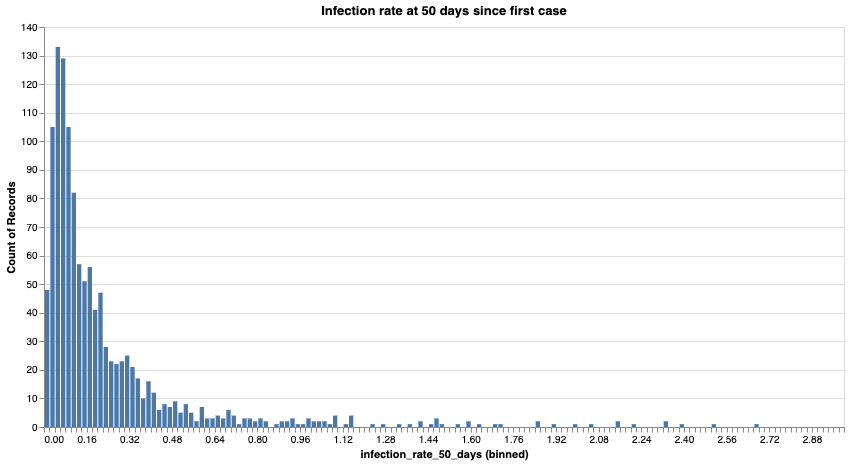

In [64]:
alt.Chart(county).mark_bar().encode(
    alt.X("infection_rate_50_days", bin=alt.Bin(extent=[0, 3], step=0.02)),
    y='count()',
).properties(
    width=800,
    height=400,
    title='Infection rate at 50 days since first case'
)

> It looks like we have a right skewness for the response variable distribution. Most counties' infection rates seem to lie below 0.8.

## Box-Cox power transformation

We do need to fix this right skewness which will pose a problem for our linear regression. We will use the [Box-Cox](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html) power transformation. 

In [65]:
infection_rate_50_days_boxcox, lmbda = stats.boxcox(county['infection_rate_50_days'])

In [66]:
lmbda

0.0442749827010597

Let the transformed rate be `x` and the old rate be `y`. 

The formula of their relationship is `(lmbda * x + 1)^(1/lambda) = y`, which in this case is approximately `(0.044x + 1)^22.73 = y`. Let's visualize what that means.

In [69]:
county['infection_rate_50_days_boxcox'] = infection_rate_50_days_boxcox

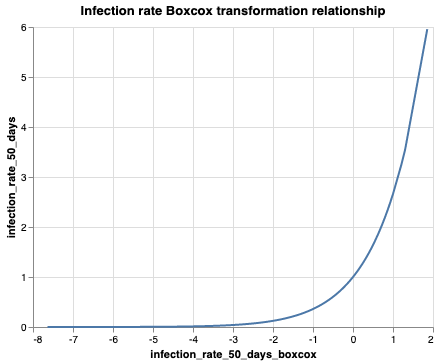

In [70]:
alt.Chart(county).mark_line().encode(
    x='infection_rate_50_days_boxcox',
    y='infection_rate_50_days'
).properties(
    title='Infection rate Boxcox transformation relationship'
)

> Basically, as the Box-Cox transformed infection rate increase, the real infection rate increases exponentially, meaning the coefficients have exponential impacts on the real infection rate.

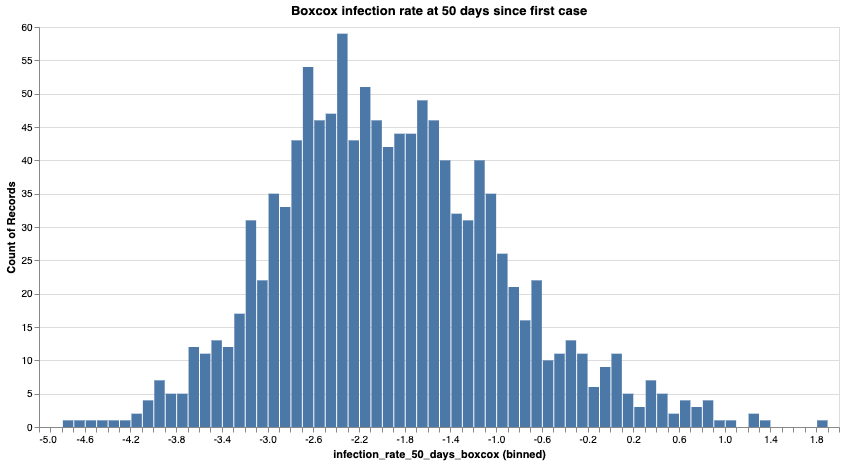

In [71]:
alt.Chart(county).mark_bar().encode(
    alt.X("infection_rate_50_days_boxcox", bin=alt.Bin(extent=[-5, 2], step=0.1)),
    y='count()',
).properties(
    width=800,
    height=400,
    title='Boxcox infection rate at 50 days since first case'
)

> The new response variable's distribution looks a lot more normal.

Next, let's look at the correlatons with the transformed rate.

In [72]:
county[county['state_governor_party'] == 'blue'].corr(method='pearson')['infection_rate_50_days_boxcox']

infection_rate                           0.743907
death_rate                               0.151545
infection_rate_50_days                   0.782449
death_rate_50_days                       0.133529
poor_general_wellbeing_fa_score          0.103682
housing_burden_fa_score                  0.071646
hispanic_relative_population_fa_score   -0.015132
inverse_sucicde_rate_fa_score            0.298527
uninsured_rate_fa_score                  0.013221
care_provider_accessibility_fa_score    -0.112372
population_youth_fa_score                0.048894
crime_risk_fa_score                     -0.205591
overall_income_fa_score                  0.302727
population_density_fa_score              0.077836
native_relative_population_fa_score     -0.052545
black_relative_population_fa_score       0.017445
urbanization_level_fa_score              0.251447
poor_food_environment_fa_score           0.019302
infection_rate_50_days_boxcox            1.000000
Name: infection_rate_50_days_boxcox, dtype: float6

> For a county in a blue state, the more prominent positively correlated factors(>.25) are **urbanization**, **income level**, and **inverse suicide**. The more prominent negatively correlated factors are **crime**(-0.2) and **care provider accessibility**(-0.1).

In [73]:
county[county['state_governor_party'] == 'red'].corr(method='pearson')['infection_rate_50_days_boxcox']

infection_rate                           0.694040
death_rate                               0.128459
infection_rate_50_days                   0.686071
death_rate_50_days                       0.097661
poor_general_wellbeing_fa_score          0.133205
housing_burden_fa_score                  0.121555
hispanic_relative_population_fa_score   -0.108134
inverse_sucicde_rate_fa_score            0.289328
uninsured_rate_fa_score                 -0.041194
care_provider_accessibility_fa_score    -0.047460
population_youth_fa_score                0.030085
crime_risk_fa_score                     -0.126457
overall_income_fa_score                  0.162245
population_density_fa_score              0.109485
native_relative_population_fa_score     -0.044598
black_relative_population_fa_score       0.214808
urbanization_level_fa_score              0.027478
poor_food_environment_fa_score           0.050181
infection_rate_50_days_boxcox            1.000000
Name: infection_rate_50_days_boxcox, dtype: float6

> For a county in a red state, the more prominent positively correlated factors(>.2) are **black population** and **inverse suicide**. The more prominent negatively correlated factors are **crime**(-0.13) and **hispanic population**(-0.11).

In [74]:
county.corr(method='pearson')['infection_rate_50_days_boxcox']

infection_rate                           0.721495
death_rate                               0.143224
infection_rate_50_days                   0.737318
death_rate_50_days                       0.119681
poor_general_wellbeing_fa_score          0.108353
housing_burden_fa_score                  0.095496
hispanic_relative_population_fa_score   -0.055940
inverse_sucicde_rate_fa_score            0.294290
uninsured_rate_fa_score                 -0.019938
care_provider_accessibility_fa_score    -0.085158
population_youth_fa_score                0.035864
crime_risk_fa_score                     -0.176715
overall_income_fa_score                  0.235176
population_density_fa_score              0.088503
native_relative_population_fa_score     -0.045037
black_relative_population_fa_score       0.114889
urbanization_level_fa_score              0.145151
poor_food_environment_fa_score           0.033627
infection_rate_50_days_boxcox            1.000000
Name: infection_rate_50_days_boxcox, dtype: float6

> Overall, the more prominent positively correlated factors(>.2) are **income level** and **inverse suicide**. The more prominent negatively correlated factors are **crime**(-0.18) and **care provider accessibility**(-0.085).

## Linearity and normality

Next, we will explore some of the more prominent explanatory variables and visualize their relationships with the infection rate as well as their distributions. We will look at common relatively significant and positively correlated explanatory variables first.

In [75]:
alt_y = alt.Y(
    'infection_rate_50_days_boxcox', 
    axis=alt.Axis(values=list(np.linspace(-6, 2, 81))),
    scale=alt.Scale(domain=(-5, 2), clamp=True)
)

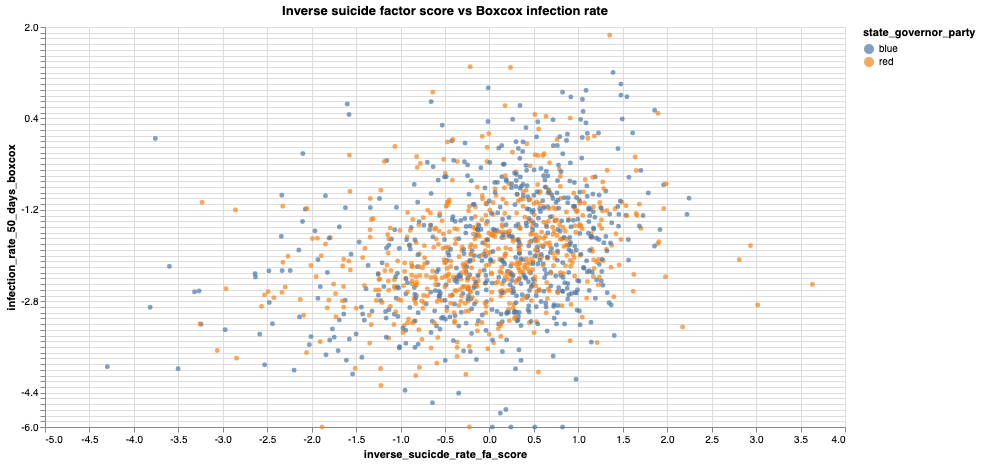

In [76]:
alt.Chart(county).mark_point(filled=True, size=22).encode(
    x='inverse_sucicde_rate_fa_score',
    y=alt_y,
    color='state_governor_party'
).properties(
    width=800,
    height=400,
    title='Inverse suicide factor score vs Boxcox infection rate'
)

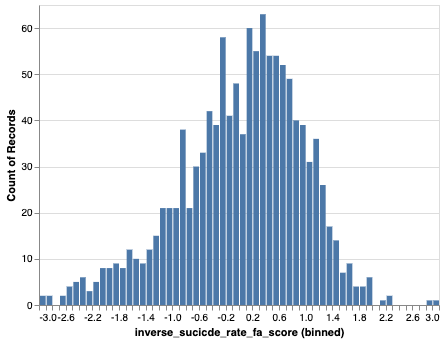

In [77]:
alt.Chart(county).mark_bar().encode(
    alt.X("inverse_sucicde_rate_fa_score", bin=alt.Bin(extent=[-3, 3], step=0.1)),
    y='count()',
)

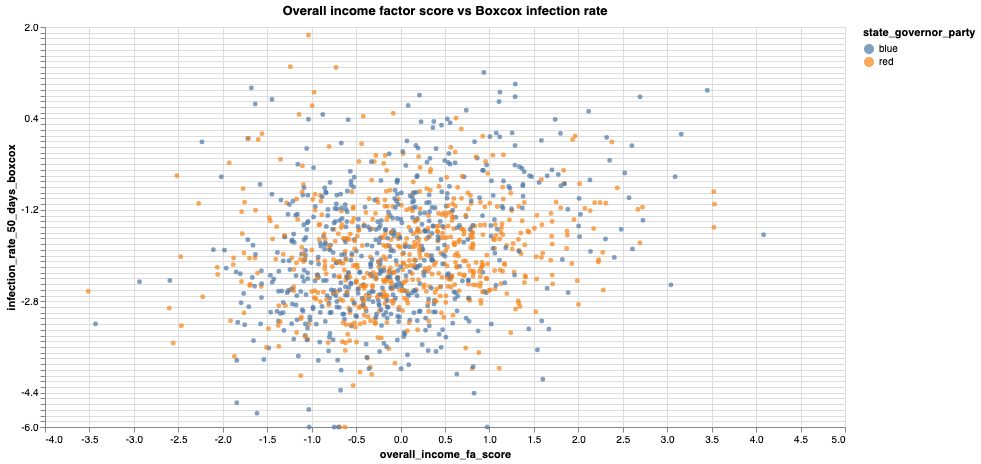

In [78]:
alt.Chart(county).mark_point(filled=True, size=22).encode(
    x='overall_income_fa_score',
    y=alt_y,
    color='state_governor_party'
).properties(
    width=800,
    height=400,
    title='Overall income factor score vs Boxcox infection rate'
)

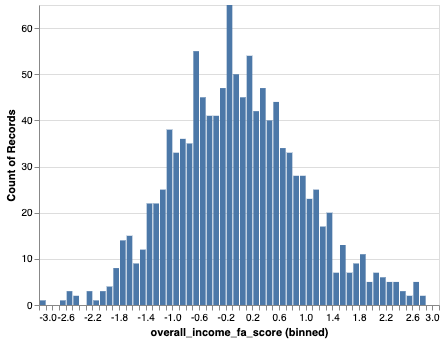

In [79]:
alt.Chart(county).mark_bar().encode(
    alt.X("overall_income_fa_score", bin=alt.Bin(extent=[-3, 3], step=0.1)),
    y='count()',
)

> As expected, though normally distributed, the above factor scores, with relatively high positive coefficients regardless of state party, have weak positive linearity relationships with the transformed infection rate.

We will look at some positively correlated explanatory variables that are relatively significant only to one party next.

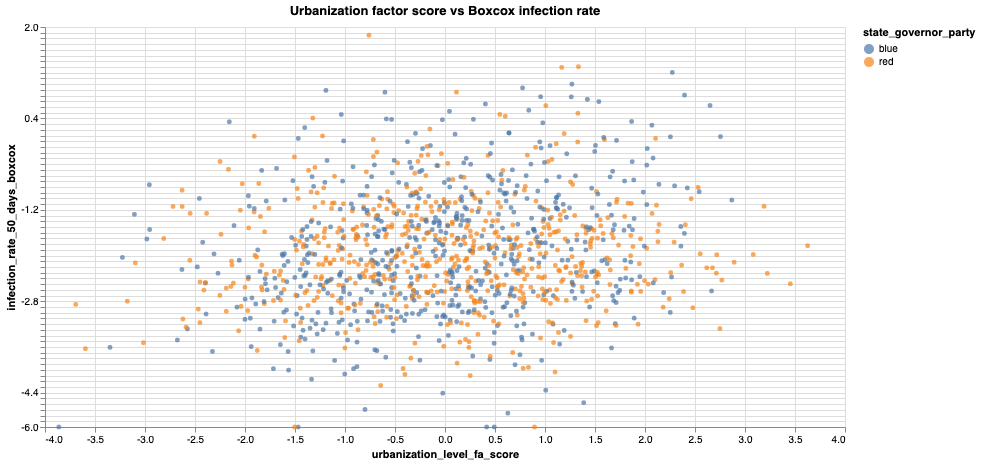

In [80]:
alt.Chart(county).mark_point(filled=True, size=22).encode(
    x='urbanization_level_fa_score',
    y=alt_y,
    color='state_governor_party'
).properties(
    width=800,
    height=400,
    title='Urbanization factor score vs Boxcox infection rate'
)

> Blue counties exhibit stronger linearity here.

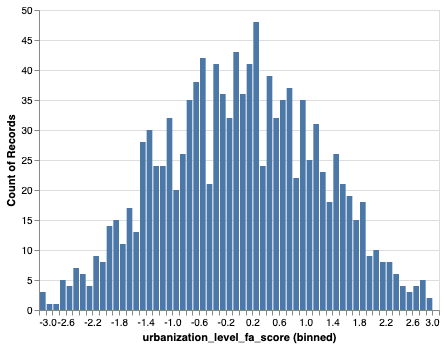

In [81]:
alt.Chart(county).mark_bar().encode(
    alt.X("urbanization_level_fa_score", bin=alt.Bin(extent=[-3, 3], step=0.1)),
    y='count()',
)

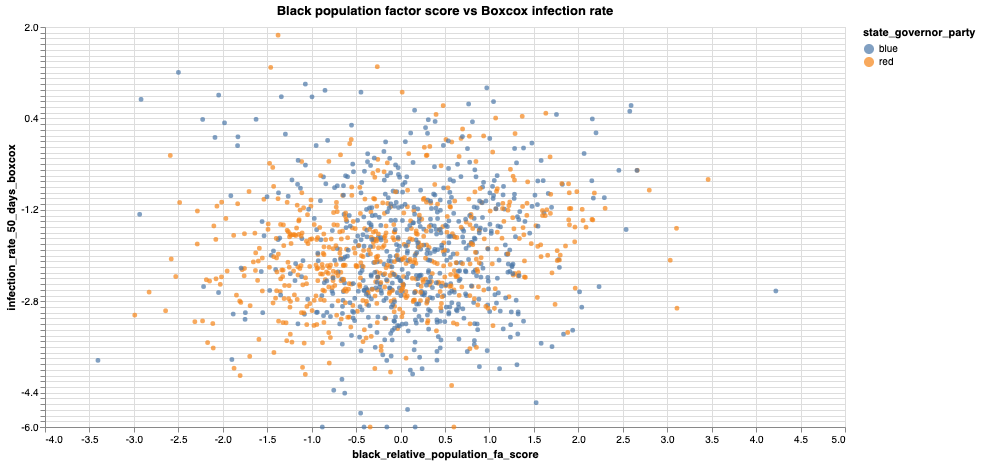

In [83]:
alt.Chart(county).mark_point(filled=True, size=22).encode(
    x='black_relative_population_fa_score',
    y=alt_y,
    color='state_governor_party'
).properties(
    width=800,
    height=400,
    title='Black population factor score vs Boxcox infection rate'
)

> Red counties exhibit slightly stronger linearity here.

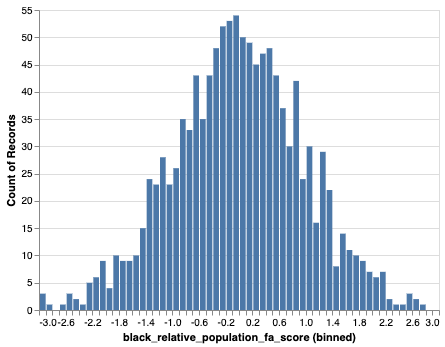

In [85]:
alt.Chart(county).mark_bar().encode(
    alt.X("black_relative_population_fa_score", bin=alt.Bin(extent=[-3, 3], step=0.1)),
    y='count()',
)

> Here we are looking at two factors that have different effects on counties in states with different governor parties. The urbanization factor has a pretty obvious but weak linearity relationship with the transformed infection rate in blue counties, but that relationship cannot be found with red counties. On the other hand, the black population factor has a very weak linearity relationship with the transformed infection rate only for counties in red states. Overall, these relationships are difficult to spot because they are not especially strong.

In conclusion, although linearity seems to be weak, it does exist for some explanatary variables with the response variable so that we can be confident on finding a somewhat useful linear equation. We can be fairly assured that decent normality is ensured and multicollinearity is alleviated with the factors. Moreover, based on the relationship graphs, we see no obvious pattern with the residuals, so we can be somewhat confident with homoscedasticity as well. With that said, we can proceed with the regression.

# Multiple linear regression

First, We will devise all combinations of model formulas and build them. Then, we will identify and explore the models with the highest adjusted R-squared, AIC, and BIC scores. Finally, we will evaluate assumptions again and interpret the models.

In [86]:
interaction_term = 'state_governor_party'
response_variable = 'infection_rate_50_days_boxcox'
explanatory_variables = fa_score_columns

In [87]:
explanatory_variables

['poor_general_wellbeing_fa_score',
 'housing_burden_fa_score',
 'hispanic_relative_population_fa_score',
 'inverse_sucicde_rate_fa_score',
 'uninsured_rate_fa_score',
 'care_provider_accessibility_fa_score',
 'population_youth_fa_score',
 'crime_risk_fa_score',
 'overall_income_fa_score',
 'population_density_fa_score',
 'native_relative_population_fa_score',
 'black_relative_population_fa_score',
 'urbanization_level_fa_score',
 'poor_food_environment_fa_score']

In [88]:
variable_combinations = []

for variable in explanatory_variables:
    variable_combinations.append([variable, variable + '*' + interaction_term])

In [89]:
formula_combinations = list(itertools.product(*variable_combinations))

In [90]:
print('There are ' + str(len(formula_combinations)) + ' combinations.')

There are 16384 combinations.


In [93]:
models = []
rsquared_adjs = []
formulas = []
aics = []
bics = []

for combo in formula_combinations:
    explanatory_variable_part = ' + '.join(combo)
    formula = ' '.join([
        'infection_rate_50_days_boxcox ~',
        explanatory_variable_part
    ])
    
    mod = smf.ols(formula=formula, data=county)
    res = mod.fit()

    models.append(res)
    formulas.append(formula)
    rsquared_adjs.append(res.rsquared_adj)
    aics.append(res.aic)
    bics.append(res.bic)
    
    if len(models)%1600 == 0:
        print(str(len(models)) + ' models finished so far!')

1600 models finished so far!
3200 models finished so far!
4800 models finished so far!
6400 models finished so far!
8000 models finished so far!
9600 models finished so far!
11200 models finished so far!
12800 models finished so far!
14400 models finished so far!
16000 models finished so far!


In [94]:
result = pd.DataFrame({
    'formula': formulas,
    'rsquared_adj': rsquared_adjs,
    'aic': aics,
    'bic': bics,
    'model': models
})

In [95]:
result.sort_values(by='rsquared_adj', ascending=False).head()

,formula,rsquared_adj,aic,bic,model
14506,infection_rate_50_days_boxcox ~ poor_general_w...,0.293079,3117.833175,3235.057766,<statsmodels.regression.linear_model.Regressio...
14522,infection_rate_50_days_boxcox ~ poor_general_w...,0.293070,3118.828542,3241.149855,<statsmodels.regression.linear_model.Regressio...
15530,infection_rate_50_days_boxcox ~ poor_general_w...,0.293014,3118.924520,3241.245834,<statsmodels.regression.linear_model.Regressio...
15546,infection_rate_50_days_boxcox ~ poor_general_w...,0.292944,3120.023282,3247.441317,<statsmodels.regression.linear_model.Regressio...
14570,infection_rate_50_days_boxcox ~ poor_general_w...,0.292887,3119.141053,3241.462367,<statsmodels.regression.linear_model.Regressio...


In [96]:
result.sort_values(by='aic').head()

,formula,rsquared_adj,aic,bic,model
14506,infection_rate_50_days_boxcox ~ poor_general_w...,0.293079,3117.833175,3235.057766,<statsmodels.regression.linear_model.Regressio...
10410,infection_rate_50_days_boxcox ~ poor_general_w...,0.292155,3118.429304,3230.557175,<statsmodels.regression.linear_model.Regressio...
14522,infection_rate_50_days_boxcox ~ poor_general_w...,0.293070,3118.828542,3241.149855,<statsmodels.regression.linear_model.Regressio...
15530,infection_rate_50_days_boxcox ~ poor_general_w...,0.293014,3118.924520,3241.245834,<statsmodels.regression.linear_model.Regressio...
14570,infection_rate_50_days_boxcox ~ poor_general_w...,0.292887,3119.141053,3241.462367,<statsmodels.regression.linear_model.Regressio...


In [97]:
result.sort_values(by='bic').head()

,formula,rsquared_adj,aic,bic,model
34,infection_rate_50_days_boxcox ~ poor_general_w...,0.283739,3128.776256,3220.517241,<statsmodels.regression.linear_model.Regressio...
42,infection_rate_50_days_boxcox ~ poor_general_w...,0.286867,3124.472511,3221.310217,<statsmodels.regression.linear_model.Regressio...
8226,infection_rate_50_days_boxcox ~ poor_general_w...,0.286008,3125.926987,3222.764693,<statsmodels.regression.linear_model.Regressio...
32,infection_rate_50_days_boxcox ~ poor_general_w...,0.278775,3136.132987,3222.777251,<statsmodels.regression.linear_model.Regressio...
0,infection_rate_50_days_boxcox ~ poor_general_w...,0.271225,3146.739872,3223.190692,<statsmodels.regression.linear_model.Regressio...


> Looks like optimizing for AIC and adjusted R-squared gives the same model, while minimizing BIC results in a different model. We will focus on these two models for the rest of the analysis.

In [98]:
aic_res = result.iloc[result.sort_values(by='aic').iloc[0].name]['model']

In [99]:
bic_res = result.iloc[result.sort_values(by='bic').iloc[0].name]['model']

Next, we will confirm whether the two models' residuals look random and are somewhat normally distributed.

In [100]:
model_df = pd.DataFrame({
    'aic_model_residual': county['infection_rate_50_days_boxcox'].values - aic_res.fittedvalues,
    'bic_model_residual': county['infection_rate_50_days_boxcox'].values - bic_res.fittedvalues,
    'real_val': county['infection_rate_50_days_boxcox'],
    'aic_model_pred': aic_res.fittedvalues,
    'bic_model_pred': bic_res.fittedvalues,
})

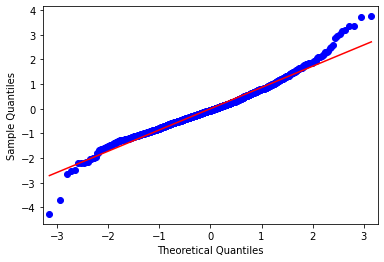

In [101]:
# QQ plot for the AIC model residuals
plt.show(qqplot(model_df['aic_model_residual'], line='s'))

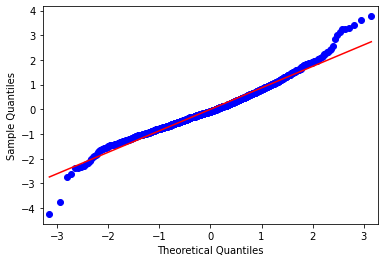

In [102]:
# QQ plot for the BIC model residuals
plt.show(qqplot(model_df['bic_model_residual'], line='s'))

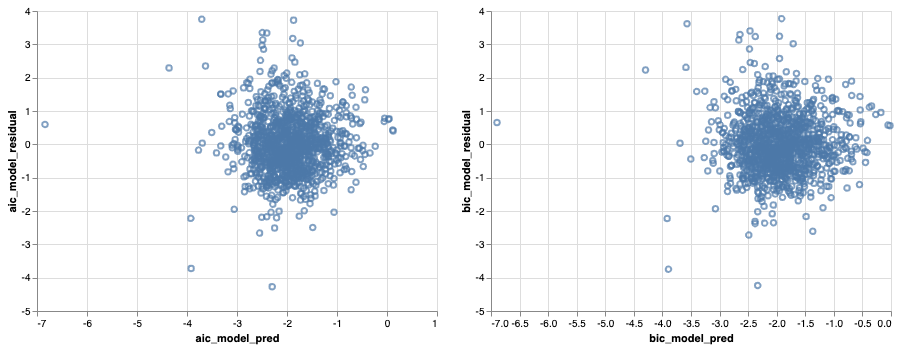

In [103]:
alt.Chart(model_df).mark_point().encode(
    x='aic_model_pred',
    y='aic_model_residual',
) | alt.Chart(model_df).mark_point().encode(
    x='bic_model_pred',
    y='bic_model_residual',
)

> The QQ plots would indicate that our residuals are normal, but their distributions do have slight heavy right tails. I think this would indicate that when the models underestimate, they tend to underestimate more compared to overestimation. The residual plots seem to display no obvious pattern.

## Model interpretation

Next, we will explore the models themselves.

In [104]:
print(aic_res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     infection_rate_50_days_boxcox   R-squared:                       0.306
Model:                                       OLS   Adj. R-squared:                  0.293
Method:                            Least Squares   F-statistic:                     23.75
Date:                           Sun, 17 May 2020   Prob (F-statistic):           1.26e-78
Time:                                   00:12:25   Log-Likelihood:                -1535.9
No. Observations:                           1208   AIC:                             3118.
Df Residuals:                               1185   BIC:                             3235.
Df Model:                                     22                                         
Covariance Type:                       nonrobust                                         
                                                                        coef    std err          t  

In [105]:
print(bic_res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     infection_rate_50_days_boxcox   R-squared:                       0.294
Model:                                       OLS   Adj. R-squared:                  0.284
Method:                            Least Squares   F-statistic:                     29.13
Date:                           Sun, 17 May 2020   Prob (F-statistic):           6.47e-78
Time:                                   00:12:27   Log-Likelihood:                -1546.4
No. Observations:                           1208   AIC:                             3129.
Df Residuals:                               1190   BIC:                             3221.
Df Model:                                     17                                         
Covariance Type:                       nonrobust                                         
                                                              coef    std err          t      P>|t| 

[Boxcox transformation](#Box-Cox-power-transformation)

[Factor interpretation](#Factor-interpretation)